# Explore FlatNet Gen

Date: 25th July 2020

## Install libraries

In [1]:
!git clone --single-branch --branch flatnet-gen https://github.com/siddiquesalman/flatnet.git
!mv flatnet/* .
!rm *.ipynb
!pip install --quiet -r requirements.txt

Cloning into 'flatnet'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (109/109), 10.76 MiB | 5.99 MiB/s, done.
Resolving deltas: 100% (21/21), done.
     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
     |████████████████████████████████| 7.4MB 47.4MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 163kB 42.4MB/s 
     |████████████████████████████████| 6.7MB 41.3MB/s 
     |████████████████████████████████| 112kB 50.0MB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
     |████████████████████████████████| 4.5MB 36.6MB/s 
     |████████████████████████████████| 133kB 50.0MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 133kB 52.3MB/s 
     |██████

## Download Ckpts and Data

In [2]:
!pip install --quiet gdown # Optional for colab, needed for local jupyter

# Ckpts
!mkdir ckpts_phase_mask_Feb_2020_size_384
!mkdir ckpts_phase_mask_Feb_2020_size_384/ours-fft-1280-1408-learn-1280-1408-meas-1280-1408
!gdown -O ckpts_phase_mask_Feb_2020_size_384/ours-fft-1280-1408-learn-1280-1408-meas-1280-1408/model_latest.pth --id 137UMvImCrnBqMsF9DCl0knxn7K2rR1mB
!gdown -O ckpts_phase_mask_Feb_2020_size_384/ours-fft-1280-1408-learn-1280-1408-meas-1280-1408/FFT_latest.pth --id 1RzBdOCQ_qxyESaJDlsgVt6rwT-pdiYDq

# See https://drive.google.com/open?id=159MsGGakny59MSXuynHMYSWiaq73o4af&authuser=ee16b068%40smail.iitm.ac.in&usp=drive_fs for more models

# PSF
!gdown -O psf.npy --id 135yE_vOhqGZw6pF8NU4EPL8986WurD75

# Masks
!gdown -O box_gaussian_1280_1408.npy --id 1_y7DYGpSQUUvMNQxEKjmDFntWNFjDNuD
!gdown -O box_gaussian_1280_1408_big_mask.npy --id 1fMIItX2Suc5HI9I-9USI-afNPOdxJlx5

Downloading...
From: https://drive.google.com/uc?id=137UMvImCrnBqMsF9DCl0knxn7K2rR1mB
To: /content/ckpts_phase_mask_Feb_2020_size_384/ours-fft-1280-1408-learn-1280-1408-meas-1280-1408/model_latest.pth
618MB [02:57, 3.48MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RzBdOCQ_qxyESaJDlsgVt6rwT-pdiYDq
To: /content/ckpts_phase_mask_Feb_2020_size_384/ours-fft-1280-1408-learn-1280-1408-meas-1280-1408/FFT_latest.pth
21.6MB [00:00, 81.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=135yE_vOhqGZw6pF8NU4EPL8986WurD75
To: /content/psf.npy
12.2MB [00:00, 107MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1_y7DYGpSQUUvMNQxEKjmDFntWNFjDNuD
To: /content/box_gaussian_1280_1408.npy
14.4MB [00:00, 87.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fMIItX2Suc5HI9I-9USI-afNPOdxJlx5
To: /content/box_gaussian_1280_1408_big_mask.npy
14.4MB [00:00, 88.1MB/s]


## Setup Args

In [3]:
# Imports
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from pathlib import Path

fft_args = {
    "psf_mat": Path("psf.npy"),
    "psf_height": 1518,
    "psf_width": 2012,
    "psf_centre_x": 808,
    "psf_centre_y": 965,
    "psf_crop_size_x": 1280,
    "psf_crop_size_y": 1408,
    "meas_height": 1518,
    "meas_width": 2012,
    "meas_centre_x": 808,
    "meas_centre_y": 965,
    "meas_crop_size_x": 1280,
    "meas_crop_size_y": 1408,
    "pad_meas_mode": "replicate",
    # Change meas_crop_size_{x,y} to crop sensor meas. This will assume your sensor is smaller than the
    # measurement size. True measurement size is 1280x1408x4. Anything smaller than this requires padding of the
    # cropped measurement and then multiplying this with gaussian filtered rectangular box. For simplicity use the arguments
    # already set. Currently we are using full measurement. 
    "image_height": 384,
    "image_width": 384,
    "fft_gamma": 20000,  # Gamma for Weiner init
    "use_mask": False,  # Use mask for cropped meas only
    "mask_path": Path("box_gaussian_1280_1408.npy"),
    # use Path("box_gaussian_1280_1408.npy") for controlled lighting
    # use Path("box_gaussian_1280_1408_big_mask.npy") for uncontrolled lighting
}

unet_args = {
    "pixelshuffle_ratio": 2,
    "batch_size": 1,
    "num_groups": 8,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu"
}

# Convert dictionary to object notation
class Tupperware(object):
    def __init__(self, entries):
        self.__dict__.update(entries)
        

unet_args.update(fft_args)
args = unet_args
args = Tupperware(args)

## FlatNet Inversion Layer

In [4]:
from models.fftlayer import fft_conv2d, get_wiener_matrix
from utils.ops import roll_n

class FFTLayer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        # Inference mode
        requires_grad = False

        psf = torch.tensor(np.load(args.psf_mat)).float()

        psf_crop_top = args.psf_centre_x - args.psf_crop_size_x // 2
        psf_crop_bottom = args.psf_centre_x + args.psf_crop_size_x // 2
        psf_crop_left = args.psf_centre_y - args.psf_crop_size_y // 2
        psf_crop_right = args.psf_centre_y + args.psf_crop_size_y // 2

        psf_crop = psf[psf_crop_top:psf_crop_bottom, psf_crop_left:psf_crop_right]

        wiener_crop = get_wiener_matrix(
            psf_crop, Gamma=args.fft_gamma, centre_roll=False
        )

        self.wiener_crop = nn.Parameter(wiener_crop, requires_grad=requires_grad)

        self.normalizer = nn.Parameter(
            torch.tensor([1 / 0.0008]).reshape(1, 1, 1, 1), requires_grad=requires_grad
        )

        if self.args.use_mask:
            mask = torch.tensor(np.load(args.mask_path)).float()
            self.mask = nn.Parameter(mask, requires_grad=False)

    def forward(self, img):
        img_h = self.args.image_height
        img_w = self.args.image_width

        pad_x = self.args.psf_height - self.args.psf_crop_size_x
        pad_y = self.args.psf_width - self.args.psf_crop_size_y

        # Pad to psf_height
        self.fft_layer = 1 * self.wiener_crop

        self.fft_layer = F.pad(
            self.fft_layer,
            (
                pad_y // 2,
                pad_y // 2,
                pad_x // 2,
                pad_x // 2,
            ),
        )

        # Centre roll
        for dim in range(2):
            self.fft_layer = roll_n(
                self.fft_layer, axis=dim, n=self.fft_layer.size(dim) // 2
            )

        self.fft_layer = self.fft_layer.unsqueeze(0).unsqueeze(0)

        _, _, fft_h, fft_w = self.fft_layer.shape

        # Convert to 0...1
        img = 0.5 * img + 0.5

        # Use mask
        if self.args.use_mask:
            img = img * self.mask

        # Do FFT convolve
        img = fft_conv2d(img, self.fft_layer) * self.normalizer

        # Centre Crop
        img = img[
              :,
              :,
              fft_h // 2 - img_h // 2: fft_h // 2 + img_h // 2,
              fft_w // 2 - img_w // 2: fft_w // 2 + img_w // 2,
              ]

        return img


## Unet Model

In [5]:
from models.unet_128 import Unet
from utils.model_serialization import load_state_dict

G = Unet(args)
FFT = FFTLayer(args)

#Specify path to the models. Trainable inversion is called FFTLayer here as it
#is implemented using FFT based learned deconvolution. Gen refers to the U-Net or perceptual enhancement stage.

# Ours
ckpt_dir = Path("ckpts_phase_mask_Feb_2020_size_384") / "ours-fft-1280-1408-learn-1280-1408-meas-1280-1408"
model_gen_path = ckpt_dir / "model_latest.pth"
model_fft_path = ckpt_dir / "FFT_latest.pth"

gen_ckpt = torch.load(model_gen_path, map_location=torch.device("cpu"))
fft_ckpt = torch.load(model_fft_path, map_location=torch.device("cpu"))

# G.load_state_dict(gen_ckpt["state_dict"])
load_state_dict(G, gen_ckpt["state_dict"])
load_state_dict(FFT, fft_ckpt["state_dict"])

device = args.device

G = G.to(device)
FFT = FFT.to(device)

## Load Sample Data

In [6]:
import cv2

# Specify path to the measurement
meas_path = Path("data/phase_images/n02165456_10030.png")  

!wget -q -O n02165456_10030.png https://raw.githubusercontent.com/siddiquesalman/flatnet/flatnet-gen/data/phase_images/n02165456_10030.png
raw = cv2.imread("n02165456_10030.png",-1) / 4096.0
raw_h, raw_w = raw.shape
img = np.zeros((raw_h // 2, raw_w // 2, 4))

img[:, :, 0] = raw[0::2, 0::2]  # r
img[:, :, 1] = raw[0::2, 1::2]  # gr
img[:, :, 2] = raw[1::2, 0::2]  # gb
img[:, :, 3] = raw[1::2, 1::2]  # b

img = torch.tensor(img)

# Crop
if args.meas_crop_size_x and args.meas_crop_size_y:
    crop_x = args.meas_centre_x - args.meas_crop_size_x // 2
    crop_y = args.meas_centre_y - args.meas_crop_size_y // 2

    # Replicate padding
    img = img[
          crop_x: crop_x + args.meas_crop_size_x,
          crop_y: crop_y + args.meas_crop_size_y,
          ]

    pad_x = args.psf_height - args.meas_crop_size_x
    pad_y = args.psf_width - args.meas_crop_size_y
    
    img = F.pad(
        img.permute(2, 0, 1).unsqueeze(0),
        (pad_y // 2, pad_y // 2, pad_x // 2, pad_x // 2),
        mode=args.pad_meas_mode,
    )

    img = img.squeeze(0).permute(1, 2, 0)

img = (img - 0.5) * 2  # Change range from -1,...,1
img = np.transpose(img, (2, 0, 1))

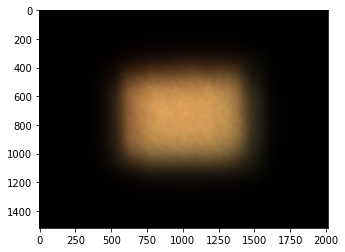

In [7]:
from matplotlib import pyplot as plt
from utils.ops import unpixel_shuffle, rggb_2_rgb

source_rgb = rggb_2_rgb(img).permute(1, 2, 0)
source_rgb = (source_rgb - source_rgb.min()) / (
    source_rgb.max() - source_rgb.min()
)
# Show measurement
plt.imshow(source_rgb.numpy())

# Forward pass
fft_output = FFT(img.unsqueeze(0).float().to(device))
fft_unpixel_shuffled = unpixel_shuffle(fft_output, args.pixelshuffle_ratio)
output_unpixel_shuffled = G(fft_unpixel_shuffled)
output = F.pixel_shuffle(output_unpixel_shuffled, args.pixelshuffle_ratio)

output_numpy = output[0].mul(0.5).add(0.5).permute(1, 2, 0).cpu().detach().numpy()

fft_output_vis = rggb_2_rgb(fft_output.squeeze(0)).mul(0.5).add(0.5)
fft_output_vis = (fft_output_vis - fft_output_vis.min()) / (fft_output_vis.max() - fft_output_vis.min())
fft_output_vis = fft_output_vis.permute(1, 2, 0).cpu().detach().numpy()

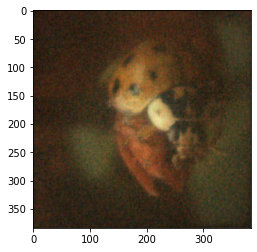

In [8]:
plt.imshow(fft_output_vis)

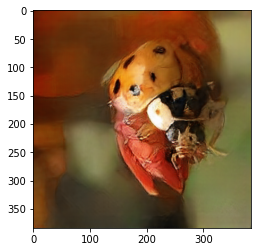

In [9]:
plt.imshow(output_numpy)